# Multiclass classification

The multiclass classification problem is a regression problem from an input $x \in {\cal X}$ to discrete labels $y\in {\cal Y}$, where ${\cal Y}$ is a discrete set of size $C$ bigger than two (for $C=2$ it is the more usual binary classification).

Labels are encoded in a one-hot fashion, that is if $C=4$ and $y=2$, we note $\bar{y} = [0,1,0,0]$.

The generative model for this problem consists of:

* $C$ latent functions $\mathbf{f} = [f_1,...,f_C]$ with an independent Gaussian Process prior
* a deterministic function that builds a discrete distribution $\pi(\mathbf{f}) = [\pi_1(f_1),...,\pi_C(f_C)]$ from the latents such that $\sum_c \pi_c(f_c) = 1$
* a discrete likelihood $p(y|\mathbf{f}) = Discrete(y;\pi(\mathbf{f})) = \prod_c \pi_c(f_c)^{\bar{y}_c}$

A typical example of $\pi$ is the softmax function:

\begin{equation}
\pi_c (f_c) \propto \exp( f_c)
\end{equation}

Another convenient one is the robust max:
\begin{equation}
\pi_c(\mathbf{f}) = \begin{cases} 1 - \epsilon, & \mbox{if } c = \arg \max_c f_c \\
 \epsilon /(C-1), & \mbox{ otherwise} \end{cases}
\end{equation}





In [1]:
import numpy as np
import tensorflow as tf

import warnings

warnings.filterwarnings("ignore")  # ignore DeprecationWarnings from tensorflow

import matplotlib.pyplot as plt

%matplotlib inline

import gpflow

from gpflow.utilities import print_summary, set_trainable
from gpflow.ci_utils import ci_niter

from multiclass_classification import plot_posterior_predictions, colors

# reproducibility:
np.random.seed(0)
tf.random.set_seed(123)

## Sampling from the GP multiclass generative model

### Declaring model parameters and input

In [2]:
# Number of functions and number of data points
C = 3
N = 100

# Lengthscale of the SquaredExponential kernel (isotropic -- change to `[0.1] * C` for ARD)
lengthscales = 0.1

# Jitter
jitter_eye = np.eye(N) * 1e-6

# Input
X = np.random.rand(N, 1)

### Sampling

In [3]:
# SquaredExponential kernel matrix
kernel_se = gpflow.kernels.SquaredExponential(lengthscales=lengthscales)
K = kernel_se(X) + jitter_eye

# Latents prior sample
f = np.random.multivariate_normal(mean=np.zeros(N), cov=K, size=(C)).T

# Hard max observation
Y = np.argmax(f, 1).flatten().astype(int)

# One-hot encoding
Y_hot = np.zeros((N, C), dtype=bool)
Y_hot[np.arange(N), Y] = 1

data = (X, Y)

### Plotting

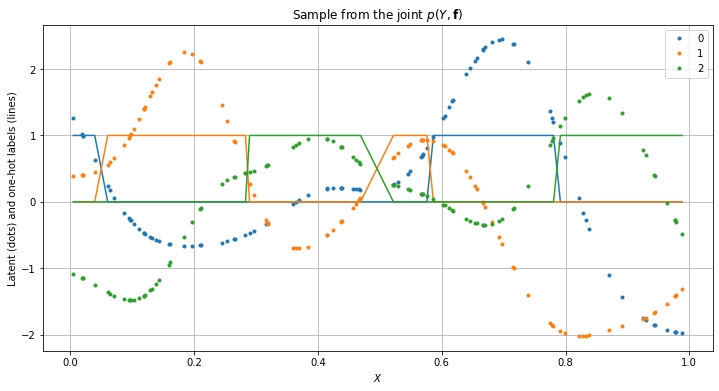

In [4]:
plt.figure(figsize=(12, 6))
order = np.argsort(X.flatten())

for c in range(C):
    plt.plot(X[order], f[order, c], ".", color=colors[c], label=str(c))
    plt.plot(X[order], Y_hot[order, c], "-", color=colors[c])


plt.legend()
plt.xlabel("$X$")
plt.ylabel("Latent (dots) and one-hot labels (lines)")
plt.title("Sample from the joint $p(Y, \mathbf{f})$")
plt.grid()
plt.show()

## Inference


Inference here consists of computing the posterior distribution over the latent functions given the data $p(\mathbf{f}|Y, X)$.

You can use different inference methods. Here we perform variational inference.
For a treatment of the multiclass classification problem using MCMC sampling, see [Markov Chain Monte Carlo (MCMC)](../advanced/mcmc.ipynb).



### Approximate inference: Sparse Variational Gaussian Process

#### Declaring the SVGP model (see [GPs for big data](../advanced/gps_for_big_data.ipynb))

In [5]:
# sum kernel: Matern32 + White
kernel = gpflow.kernels.Matern32() + gpflow.kernels.White(variance=0.01)

# Robustmax Multiclass Likelihood
invlink = gpflow.likelihoods.RobustMax(C)  # Robustmax inverse link function
likelihood = gpflow.likelihoods.MultiClass(3, invlink=invlink)  # Multiclass likelihood
Z = X[::5].copy()  # inducing inputs

m = gpflow.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=Z,
    num_latent_gps=C,
    whiten=True,
    q_diag=True,
)

# Only train the variational parameters
set_trainable(m.kernel.kernels[1].variance, False)
set_trainable(m.inducing_variable, False)
print_summary(m, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.009999999999999998
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(20, 1)",float64,[[0.5488135...
SVGP.q_mu,Parameter,Identity,,True,"(20, 3)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,Softplus,,True,"(20, 3)",float64,"[[1., 1., 1...."


#### Running inference

In [6]:
opt = gpflow.optimizers.Scipy()

opt_logs = opt.minimize(
    m.training_loss_closure(data), m.trainable_variables, options=dict(maxiter=ci_niter(1000))
)
print_summary(m, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,156886.68783887077
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.17427842722718734
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.009999999999999998
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(20, 1)",float64,[[0.5488135...
SVGP.q_mu,Parameter,Identity,,True,"(20, 3)",float64,"[[-2.32589301e-01, 6.14343482e-01, -3.81754181e-01..."
SVGP.q_sqrt,Parameter,Softplus,,True,"(20, 3)",float64,"[[0.08266212, 0.07959608, 0.12088343..."


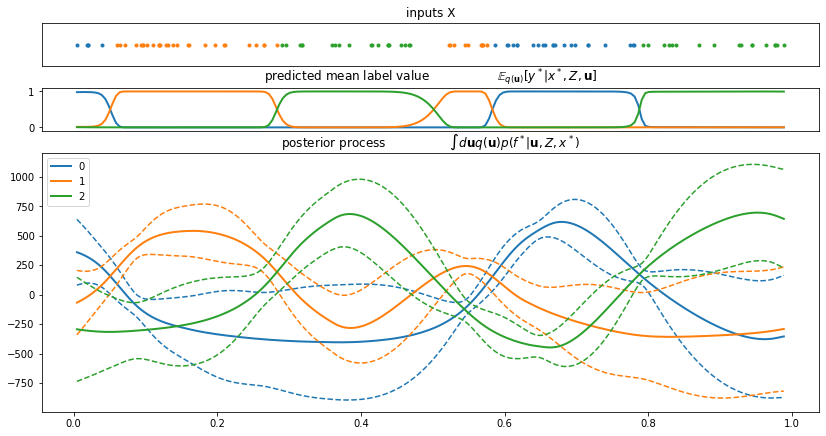

In [7]:
plot_posterior_predictions(m, X, Y)